<a href="https://colab.research.google.com/github/nkurinsky/THz-FTS/blob/master/python/Notebooks/DataAna/BREADPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In order to run this code, ensure that the data files (from the shared google drive folder "BREAD Experiment" are saved to your personal google drive with the correct folder path:

folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/'

In [173]:
from google.colab import drive
from pylab import figure
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import numpy as np
import scipy as sp
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from pylab import imshow, colorbar

In [174]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [175]:
calculate_chi_sqs = True

In [176]:
#filtertype is a string refering to datafile
#seconds is the number of seconds that the source waited before increasing voltage more
def get_data_auto(filtertype, seconds):
  data_per_second = 5
  indexs = np.arange(0, len(d_0['time_' + filtertype]), data_per_second*seconds)
  averages = []
  std_errors = []
  voltages = []
  
  for x in d_0['time_log_' + filtertype]:
    voltages.append(x[0])

  for i in range(len(indexs)-1):
    list1 = d_0['power_' + filtertype][indexs[i]:indexs[i+1]]
    array1 = np.asarray(list1, dtype=np.float32)
    avg = np.mean(array1)
    
    std_dev = np.sqrt(np.var(array1))
    std_error = std_dev/np.sqrt(len(list1))
    averages.append(avg)
    std_errors.append(std_error)
  return voltages, averages, std_errors


In [177]:
def fill_time_log_array(filtertype, seconds, start_v, increase_v):
  data_per_second = 5
  for i in range(int(len(d_0['power_' + filtertype])/(seconds*data_per_second))):
    v = round(start_v + increase_v*i, 5) #round voltage to only 3 numbers
    t0 = d_0['time_' + filtertype][0] + seconds*i
    t1 = d_0['time_' + filtertype][0] + seconds * (i + 1)
    d_0['time_log_' + filtertype].append([v, t0, t1])
  return

In [178]:
# from the IR-Si253 voltage temperature plot (https://www.boselec.com/wp-content/uploads/Linear/IRSources/IRSourcesLiterature/IR-Si253-Series-formerly-IR-18-and-IR-19.pdf), were able to extract data points and fit to a polynomial using excel. 
# The equation seen here is the corresponding relationship between voltage (V) and temperature (K)
# Note that these values are no longer valid after the "plateu" that is seen becasue of the max current in the UPS
def Si253_temp(v):
  t = []
  for i in range(len(v)):
    t.append( -3.5727 * v[i]**2 + 136.61*v[i] + 294.53)
  return t

In [179]:
# from the IR-12K voltage temperature plot (https://www.boselec.com/wp-content/uploads/Linear/IRSources/IRSourcesLiterature/IR-12-and-12K-with-engineering-data-and-reflectors.pdf), were able to extract data points and fit to a polynomial using excel. 
# The equation seen here is the corresponding relationship between voltage (V) and temperature (K)
# Note that these values are no longer valid after the "plateu" that is seen becasue of the max current in the UPS
def IR12K_temp(v):
  t = []
  for i in range(len(v)):
    t.append( -4.4418 * v[i]**2 + 195.04*v[i] + 26.056 + 273.15)
  return t

In [180]:
def get_power(filtertype_volt_array, filtertype_power_array, voltage):
  power = 0
  for i in range(len(filtertype_volt_array)):
    if filtertype_volt_array[i] == voltage:
      power = filtertype_power_array[i]
  return power

In [181]:
def get_fit_range(temp_list, power_list):
  chi_sqs = []
  min_chisq = 99
  start_best = 0
  end_best = 0
  
  for start in range(len(temp_list)):
    chi_sq_start = []
    for end in range(len(temp_list)):
      if start >= end:
        chi_sq_start.append(np.nan)
      else:
        chi_sq = 0.0
        for i in range(start, end):
          p = np.polyfit(np.log10(temp_list[start:end]), np.log10(power_list[start:end]), 1)
          fit_func = np.poly1d(p)
          chi_sq += (np.log10(power_list[i]) - fit_func(np.log10(temp_list[i])))**2/ np.sqrt(abs(fit_func(np.log10(temp_list[i]))))
        chi_sq_start.append(chi_sq)
        if (chi_sq < min_chisq) and (start + int(len(temp_list)/2) <= end) and (start > int(len(temp_list)/8)): #want to include at least half of data points 
          min_chisq = chi_sq
          start_best = start
          end_best = end
          #print("min chi squared updated to ", chi_sq, " with range: [", start, ",", end , "]")
    chi_sqs.append(chi_sq_start)
    
  total_num = len(chi_sqs)**2/2
  fig = figure(figsize=(8, 6), dpi=100)
  current_cmap = cm.get_cmap()
  current_cmap.set_bad(color='white')
  chi_sqs_array = np.array(chi_sqs)
  imshow(chi_sqs_array/total_num, origin = "lower", aspect = 1) #plots density plot
  colorbar()

  circle = plt.Circle((end_best, start_best), 1, color='r', fill=False)
  plt.gca().add_artist(circle)
  
  plt.title("Reduced Chi Squared")
  plt.xlabel("end index for fit")
  plt.ylabel("start index for fit")

  print("the range for fit (including at least 1/2 the data points) is: [", start_best, ',' , end_best, "], with chi squared = ", chi_sq)
  return(start_best, end_best, chi_sq)

Here is where I define all of the file paths, to get the data out of google drive. There are many variations of the same data run taken with slightly different parameters as an investigation. 

In [182]:
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/'

data_SiWfilter_Si207 = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_SiW_filter.csv")
data_PEWfilter_Si207 = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_PEW_filter.csv")
data_nofilter_Si207 = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_no_filter.csv")
data_nofilter_Si207_633nm = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_no_filter_633nm.csv")
data_nofilter_Si207_1e4nm = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_no_filter_1e4nm.csv")
data_nofilter_Si207_5e4nm = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_no_filter_5e4nm.csv")
data_nofilter_Si207_3e5nm = pd.read_csv(folder_path + "Si207_keyhole/IR-Si207_no_filter_3e5nm.csv")

data_SiWfilter_Si253 = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_SiW_filter.csv")
data_PEWfilter_Si253 = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_PEW_filter.csv")
data_nofilter_Si253 = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter.csv")
data_nofilter_Si253_1e5nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_1e5nm.csv")
data_nofilter_Si253_1e4nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_1e4nm.csv")
data_nofilter_Si253_5e4nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_5e4nm.csv")
data_nofilter_Si253_633nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_633nm.csv")
data_nofilter_Si253_6e5nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_6e5nm.csv")
data_nofilter_Si253_3e6nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_3e6nm.csv")
data_nofilter_Si253_3e5nm = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_3e5nm.csv")
data_nofilter_Si253_30sec = pd.read_csv(folder_path + "Si253_keyhole/IR-Si253_no_filter_30sec.csv")

data_nofilter_Si253_block = pd.read_csv(folder_path + "Si253_block/IR-Si253_no_filter_3e5nm_cardboard.csv")

data_nofilter_IR12K = pd.read_csv(folder_path + "IR-12K_keyhole/IR-12K_no_filter.csv")

data_nofilter_EVF_5551 = pd.read_csv(folder_path + "EVF-5551_keyhole/EVF-5551_no_filter.csv")
data_nofilter_EVF_5551_try2 = pd.read_csv(folder_path + "EVF-5551_keyhole/EVF-5551_no_filter_try2.csv")

data_nofilter_EVF_5550 = pd.read_csv(folder_path + "EVF-5550_keyhole/EVF-5550_no_filter.csv")
data_nofilter_EVF_5550_try2 = pd.read_csv(folder_path + "EVF-5550_keyhole/EVF-5550_no_filter_try2.csv")

data_LED_nofilter = pd.read_csv(folder_path + "LED/LED_nofilter.csv")
data_LED_SiWfilter1 = pd.read_csv(folder_path + "LED/LED_SiWfilter_1.csv")
data_LED_SiWfilter2 = pd.read_csv(folder_path + "LED/LED_SiWfilter_2.csv")
data_LED_PEWfilter1 = pd.read_csv(folder_path + "LED/LED_PEWfilter_1.csv")
data_LED_PEWfilter2 = pd.read_csv(folder_path + "LED/LED_PEWfilter_2.csv")

data_nosource = pd.read_csv(folder_path + "nosource.csv")

Si253_temp_manual = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual.csv")
Si207_temp_manual = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si207_temp_manual.csv")
IR12K_temp_manual = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/IR-12K_temp_manual.csv")

## Si253 Source Plots

In [183]:
d_0 = {
'time_log_nofilter_Si253' : [],
'time_log_nofilter_Si253_633nm' : [],
'time_log_nofilter_Si253_1e5nm' : [],
'time_log_nofilter_Si253_1e4nm' : [],
'time_log_nofilter_Si253_5e4nm' : [],
'time_log_nofilter_Si253_6e5nm' : [],
'time_log_nofilter_Si253_3e5nm' : [],
'time_log_nofilter_Si253_3e6nm' : [],
'time_log_nofilter_Si253_30sec' : [],
'time_log_nofilter_Si253_block' : [],
'time_log_PEWfilter_Si253' : [],
'time_log_SiWfilter_Si253' : [],

'power_nofilter_Si253' : data_nofilter_Si253['power'],
'time_nofilter_Si253' : np.arange(0, len(data_nofilter_Si253['power'])/5, 0.2),

'power_nofilter_Si253_633nm' : data_nofilter_Si253_633nm['power'],
'time_nofilter_Si253_633nm' : np.arange(0, len(data_nofilter_Si253_633nm['power'])/5, 0.2),

'power_nofilter_Si253_1e4nm' : data_nofilter_Si253_1e4nm['power'],
'time_nofilter_Si253_1e4nm' : np.arange(0, len(data_nofilter_Si253_1e4nm['power'])/5, 0.2),

'power_nofilter_Si253_1e5nm' : data_nofilter_Si253_1e5nm['power'],
'time_nofilter_Si253_1e5nm' : np.arange(0, len(data_nofilter_Si253_1e5nm['power'])/5, 0.2),

'power_nofilter_Si253_5e4nm' : data_nofilter_Si253_5e4nm['power'],
'time_nofilter_Si253_5e4nm' : np.arange(0, len(data_nofilter_Si253_5e4nm['power'])/5, 0.2),

'power_nofilter_Si253_6e5nm' : data_nofilter_Si253_6e5nm['power'],
'time_nofilter_Si253_6e5nm' : np.arange(0, len(data_nofilter_Si253_6e5nm['power'])/5, 0.2),

'power_nofilter_Si253_3e5nm' : data_nofilter_Si253_3e5nm['power'],
'time_nofilter_Si253_3e5nm' : np.arange(0, len(data_nofilter_Si253_3e5nm['power'])/5, 0.2),

'power_nofilter_Si253_3e6nm' : data_nofilter_Si253_3e6nm['power'],
'time_nofilter_Si253_3e6nm' : np.arange(0, len(data_nofilter_Si253_3e6nm['power'])/5, 0.2),

'power_nofilter_Si253_30sec' : data_nofilter_Si253_30sec['power'],
'time_nofilter_Si253_30sec' : np.arange(0, len(data_nofilter_Si253_30sec['power'])/5, 0.2),

'power_nofilter_Si253_block' : data_nofilter_Si253_block['power'],
'time_nofilter_Si253_block' : np.arange(0, len(data_nofilter_Si253_block['power'])/5, 0.2),

'power_PEWfilter_Si253' : data_PEWfilter_Si253['power'],
'time_PEWfilter_Si253' : np.arange(0, len(data_PEWfilter_Si253['power'])/5, 0.2),

'power_SiWfilter_Si253' : data_SiWfilter_Si253['power'],
'time_SiWfilter_Si253' : np.arange(0, len(data_SiWfilter_Si253['power'])/5, 0.2)
}

seconds = 15
start_v = 1.1 #V
increase_v = 0.1 #V
fill_time_log_array('SiWfilter_Si253', seconds, start_v, increase_v)
fill_time_log_array('PEWfilter_Si253', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_633nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_1e5nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_1e4nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_5e4nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_3e5nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_3e6nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_6e5nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si253_30sec', 30, start_v, increase_v)
fill_time_log_array('nofilter_Si253_block', seconds, start_v, increase_v)

nofilter_voltages_Si253, nofilter_averages_Si253, nofilter_std_error_Si253 = get_data_auto('nofilter_Si253', seconds)
nofilter_voltages_Si253_633nm, nofilter_averages_Si253_633nm, nofilter_std_error_Si253_633nm = get_data_auto('nofilter_Si253_633nm', seconds)
nofilter_voltages_Si253_1e5nm, nofilter_averages_Si253_1e5nm, nofilter_std_error_Si253_1e5nm = get_data_auto('nofilter_Si253_1e5nm', seconds)
nofilter_voltages_Si253_1e4nm, nofilter_averages_Si253_1e4nm, nofilter_std_error_Si253_1e4nm = get_data_auto('nofilter_Si253_1e4nm', seconds)
nofilter_voltages_Si253_5e4nm, nofilter_averages_Si253_5e4nm, nofilter_std_error_Si253_5e4nm = get_data_auto('nofilter_Si253_5e4nm', seconds)
nofilter_voltages_Si253_3e5nm, nofilter_averages_Si253_3e5nm, nofilter_std_error_Si253_3e5nm = get_data_auto('nofilter_Si253_3e5nm', seconds)
nofilter_voltages_Si253_3e6nm, nofilter_averages_Si253_3e6nm, nofilter_std_error_Si253_3e6nm = get_data_auto('nofilter_Si253_3e6nm', seconds)
nofilter_voltages_Si253_6e5nm, nofilter_averages_Si253_6e5nm, nofilter_std_error_Si253_6e5nm = get_data_auto('nofilter_Si253_6e5nm', seconds)
nofilter_voltages_Si253_30sec, nofilter_averages_Si253_30sec, nofilter_std_error_Si253_30sec = get_data_auto('nofilter_Si253_30sec', 30)
nofilter_voltages_Si253_block, nofilter_averages_Si253_block, nofilter_std_error_Si253_block = get_data_auto('nofilter_Si253_block', seconds)
PEWfilter_voltages_Si253, PEWfilter_averages_Si253, PEWfilter_std_error_Si253 = get_data_auto('PEWfilter_Si253', seconds)
SiWfilter_voltages_Si253, SiWfilter_averages_Si253, SiWfilter_std_error_Si253 = get_data_auto('SiWfilter_Si253', seconds)

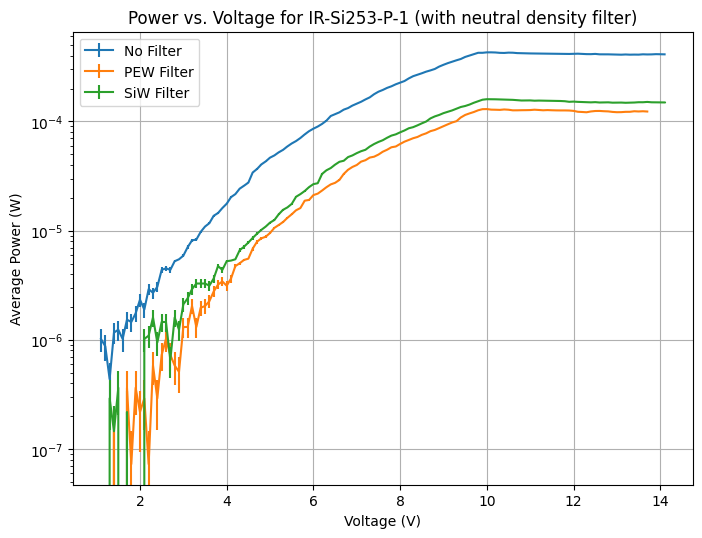

In [184]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si253, nofilter_averages_Si253, yerr = nofilter_std_error_Si253, label = "No Filter")
plt.errorbar(PEWfilter_voltages_Si253, PEWfilter_averages_Si253, yerr = PEWfilter_std_error_Si253, label = "PEW Filter")
plt.errorbar(SiWfilter_voltages_Si253, SiWfilter_averages_Si253, yerr = SiWfilter_std_error_Si253, label = "SiW Filter")
plt.title("Power vs. Voltage for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

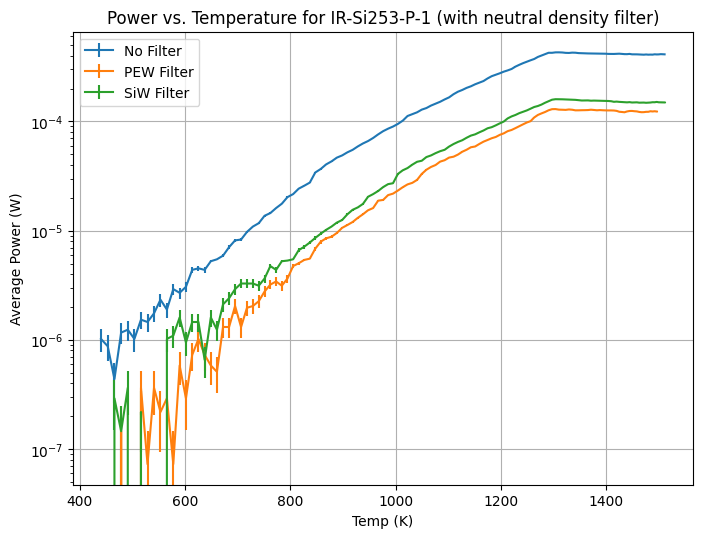

In [185]:
nofilter_temps_Si253 = Si253_temp(nofilter_voltages_Si253)
PEWfilter_temps_Si253 = Si253_temp(PEWfilter_voltages_Si253)
SiWfilter_temps_Si253 = Si253_temp(SiWfilter_voltages_Si253)

fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_temps_Si253, nofilter_averages_Si253, yerr = nofilter_std_error_Si253, label = "No Filter")
plt.errorbar(PEWfilter_temps_Si253, PEWfilter_averages_Si253, yerr = PEWfilter_std_error_Si253, label = "PEW Filter")
plt.errorbar(SiWfilter_temps_Si253, SiWfilter_averages_Si253, yerr = SiWfilter_std_error_Si253, label = "SiW Filter")

plt.title("Power vs. Temperature for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Temp (K)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

This upcoming plot is the most interesting data point for the Si253 source: the Power Law extracted as measured optical power as a function of input power to the source. The first plot is for no filter, the following is for the SiW filter, and the third is for the PEW filter.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

the range for fit (including at least 1/2 the data points) is: [ 26 , 91 ], with chi squared =  4.2876024051216646e-31
Fit: y = 6.23x + -22.7 (with $\chi^2 = $ 4.29e-31)
The diagonal elements of the covariance matrix are  [0.04132846 0.12474372]
error on the slope is  0.3531907742078087


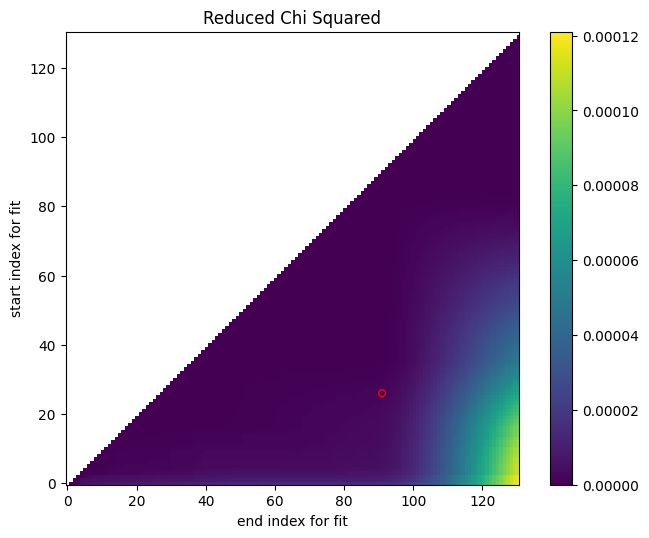

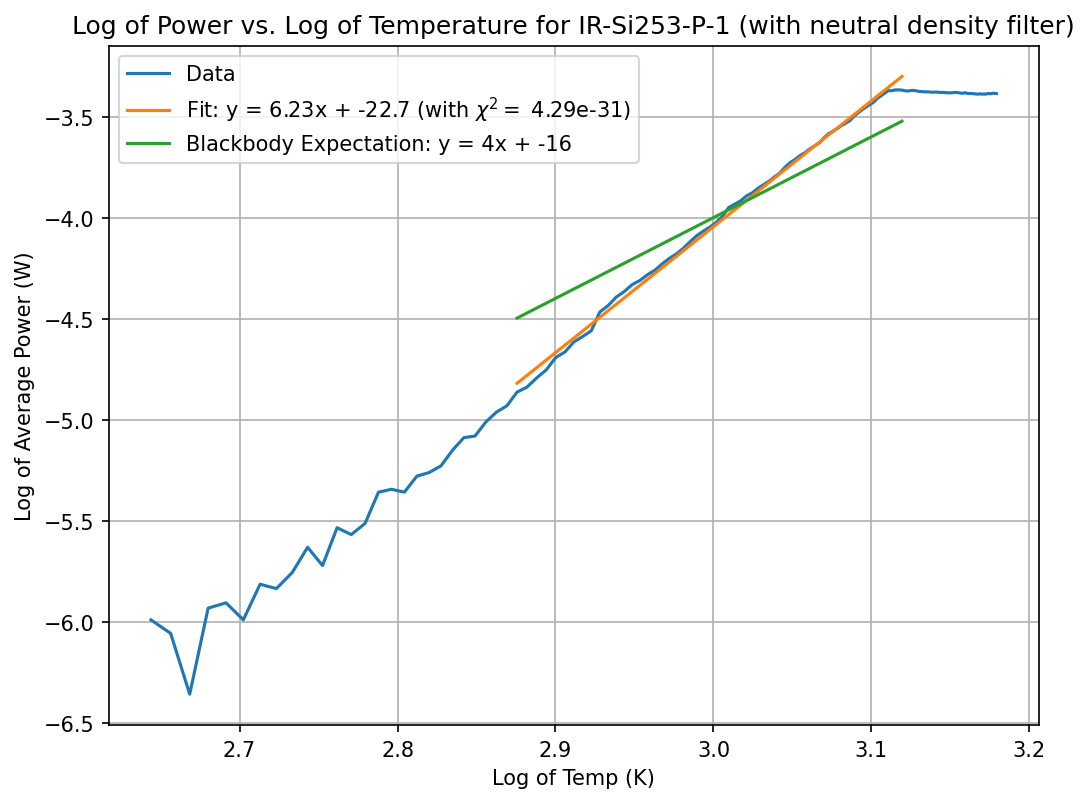

In [186]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)

if calculate_chi_sqs:
  start, end, chi = get_fit_range(nofilter_temps_Si253, nofilter_averages_Si253)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 26
  end = 91
  chi = 4.2876024051216646e-31

fig = figure(figsize=(8, 6), dpi=150)
p, cov = np.polyfit(np.log10(nofilter_temps_Si253[start:end]), np.log10(nofilter_averages_Si253[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit = np.poly1d(p)
fit_string = 'Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit[1], fit[0], chi)
print(fit_string)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 

t = np.linspace(np.log10(nofilter_temps_Si253[start]), np.log10(nofilter_temps_Si253[end]), 100)


plt.plot(np.log10(nofilter_temps_Si253), np.log10(nofilter_averages_Si253), label = "Data")
plt.plot(t, fit(t), label = fit_string)
plt.plot(t, 4*t -16, label = "Blackbody Expectation: y = 4x + -16")
plt.title("Log of Power vs. Log of Temperature for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykern

the range for fit (including at least 1/2 the data points) is: [ 24 , 89 ], with chi squared =  1.6132729404085658e-30
Fit: y = 6.97x + -25.5 (with $\chi^2 = $ 1.61e-30)
The diagonal elements of the covariance matrix are  [0.05034747 0.15158167]
error on the slope is  0.389334907937034


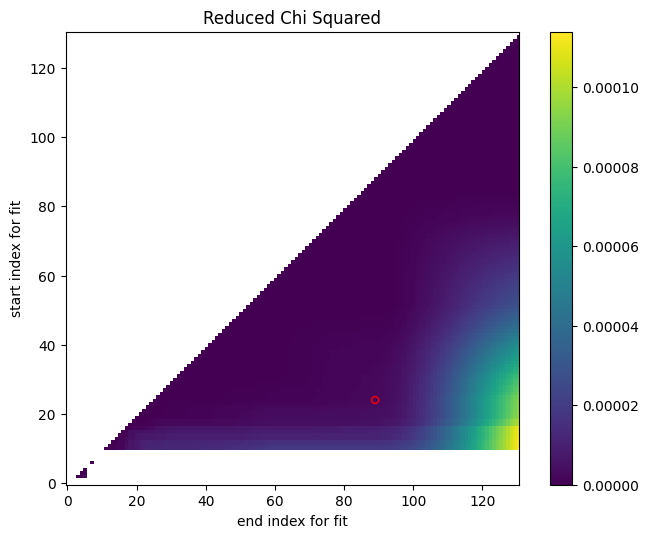

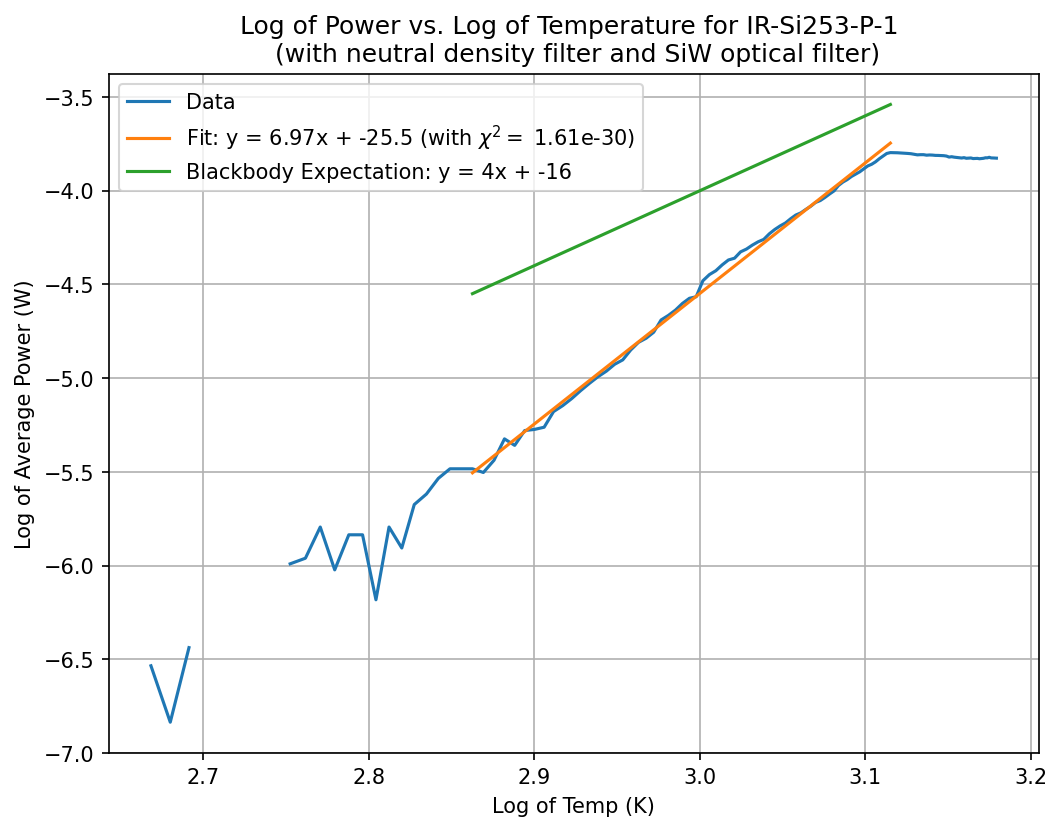

In [187]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)
if calculate_chi_sqs:
  start, end, chi = get_fit_range(SiWfilter_temps_Si253, SiWfilter_averages_Si253)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 24
  end = 89
  chi = 1.6132729404085658e-30

fig = figure(figsize=(8, 6), dpi=150)

p, cov = np.polyfit(np.log10(SiWfilter_temps_Si253[start:end]), np.log10(SiWfilter_averages_Si253[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit_SiW = np.poly1d(p)
fit_string_SiW = 'Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit_SiW[1], fit_SiW[0], chi )
print(fit_string_SiW)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 

t = np.linspace(np.log10(SiWfilter_temps_Si253[start]), np.log10(SiWfilter_temps_Si253[end]), 100)


plt.plot(np.log10(SiWfilter_temps_Si253), np.log10(SiWfilter_averages_Si253), label = "Data")
plt.plot(t, fit_SiW(t), label = fit_string_SiW)
plt.plot(t, 4*t -16, label = "Blackbody Expectation: y = 4x + -16")
plt.title("Log of Power vs. Log of Temperature for IR-Si253-P-1 \n (with neutral density filter and SiW optical filter)")
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after re

the range for fit (including at least 1/2 the data points) is: [ 26 , 89 ], with chi squared =  8.979850377962963e-31
Fit: y = 6.23x + -22.7 (with $\chi^2 = $ 4.29e-31)
The diagonal elements of the covariance matrix are  [0.04986276 0.15034582]
error on the slope is  0.3877445274162026


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


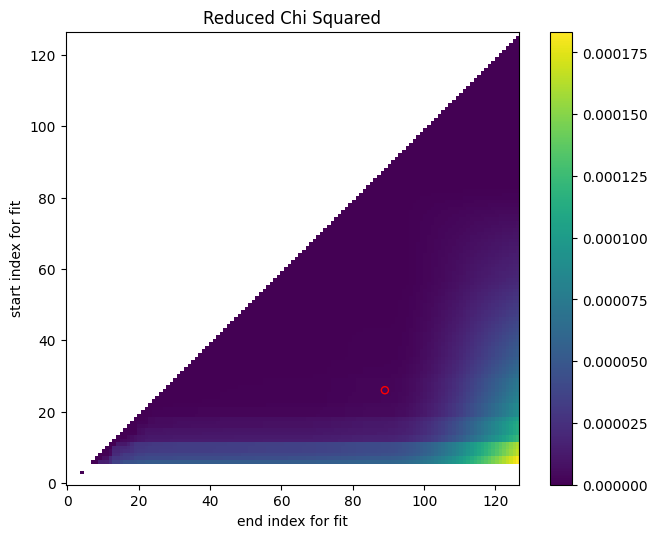

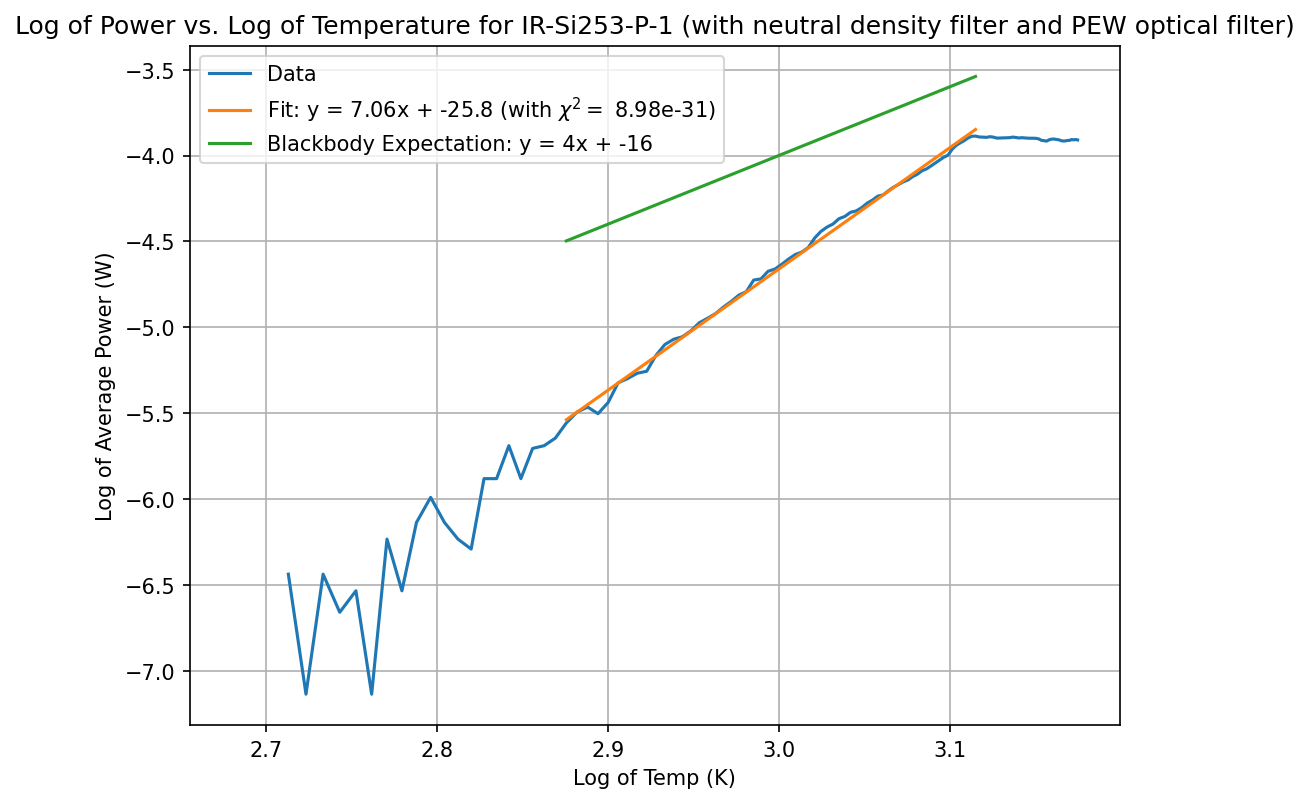

In [188]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)

if calculate_chi_sqs:
  start, end, chi = get_fit_range(PEWfilter_temps_Si253, PEWfilter_averages_Si253)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 26
  end = 89
  chi =  8.979850377962963e-31

fig = figure(figsize=(8, 6), dpi=150)

p, cov = np.polyfit(np.log10(PEWfilter_temps_Si253[start:end]), np.log10(PEWfilter_averages_Si253[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit_PEW = np.poly1d(p)
fit_string_PEW = 'Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit_PEW[1], fit_PEW[0], chi)
print(fit_string)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 
t = np.linspace(np.log10(PEWfilter_temps_Si253[start]), np.log10(PEWfilter_temps_Si253[end]), 100)


plt.plot(np.log10(PEWfilter_temps_Si253), np.log10(PEWfilter_averages_Si253), label = "Data")
plt.plot(t, fit_PEW(t), label = fit_string_PEW)
plt.plot(t, 4*t -16, label = "Blackbody Expectation: y = 4x + -16")
plt.title("Log of Power vs. Log of Temperature for IR-Si253-P-1 (with neutral density filter and PEW optical filter)")
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

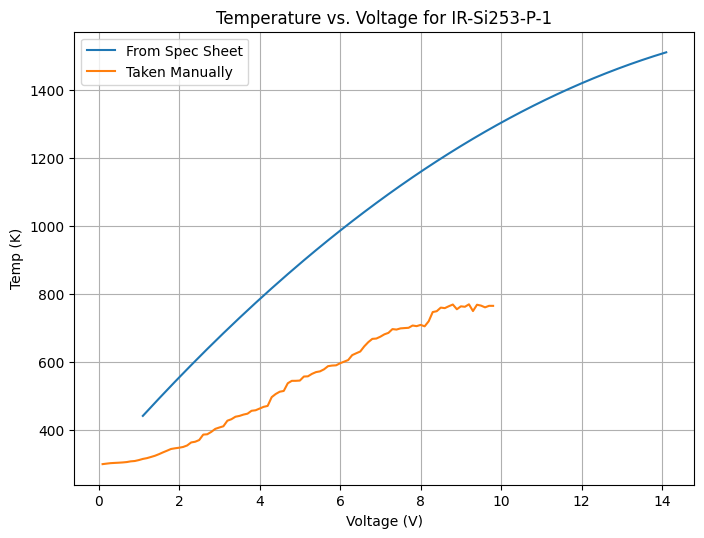

In [189]:
cleanedTempList = [x for x in Si253_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in Si253_temp_manual['Voltage'] if str(x) != 'nan']

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(nofilter_voltages_Si253, nofilter_temps_Si253, label = "From Spec Sheet")
plt.plot(cleanedVoltList, cleanedTempList, label = "Taken Manually")
plt.title("Temperature vs. Voltage for IR-Si253-P-1")
plt.xlabel("Voltage (V)")
plt.ylabel("Temp (K)")

plt.legend()
plt.grid(True)
plt.show()

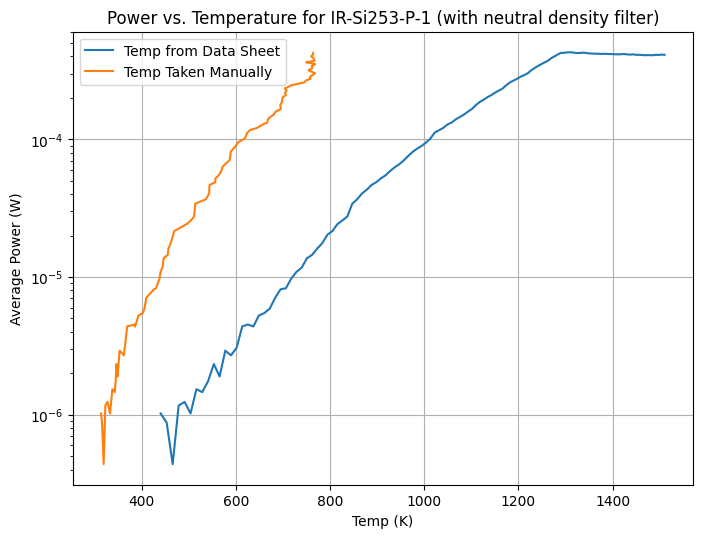

In [190]:
#eliminating any nan elements in the list
cleanedTempList = [x for x in Si253_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in Si253_temp_manual['Voltage'] if str(x) != 'nan']

#constructing a lookup table from voltages to temperatures 
temp_ranges = [cleanedTempList[v] for v in range(len(cleanedVoltList))] 
Si253_volt_to_temp_manual = dict(zip(cleanedVoltList, temp_ranges))

temp = []
power = []
for i in range(len(nofilter_voltages_Si253)):
  if i < len(cleanedTempList)-10:
    temp.append(Si253_volt_to_temp_manual[nofilter_voltages_Si253[i]])
    power.append(nofilter_averages_Si253[i])

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(nofilter_temps_Si253, nofilter_averages_Si253, label = "Temp from Data Sheet")
plt.plot(temp, power, label = "Temp Taken Manually")
plt.title("Power vs. Temperature for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Temp (K)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

the range for fit (including at least 1/2 the data points) is: [ 38 , 82 ], with chi squared =  9.649005409101195e-31
Manual Fit: y = 5.61x + -19.7 (with $\chi^2 = $ 9.65e-31)
The diagonal elements of the covariance matrix are  [0.10324246 0.29114445]
error on the slope is  0.5395780270476119


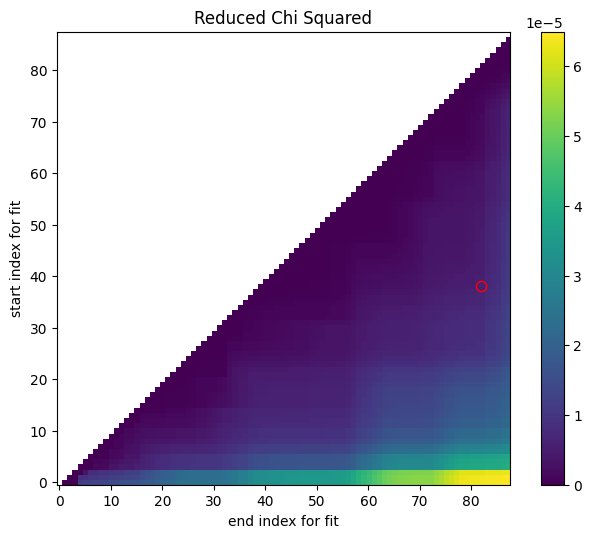

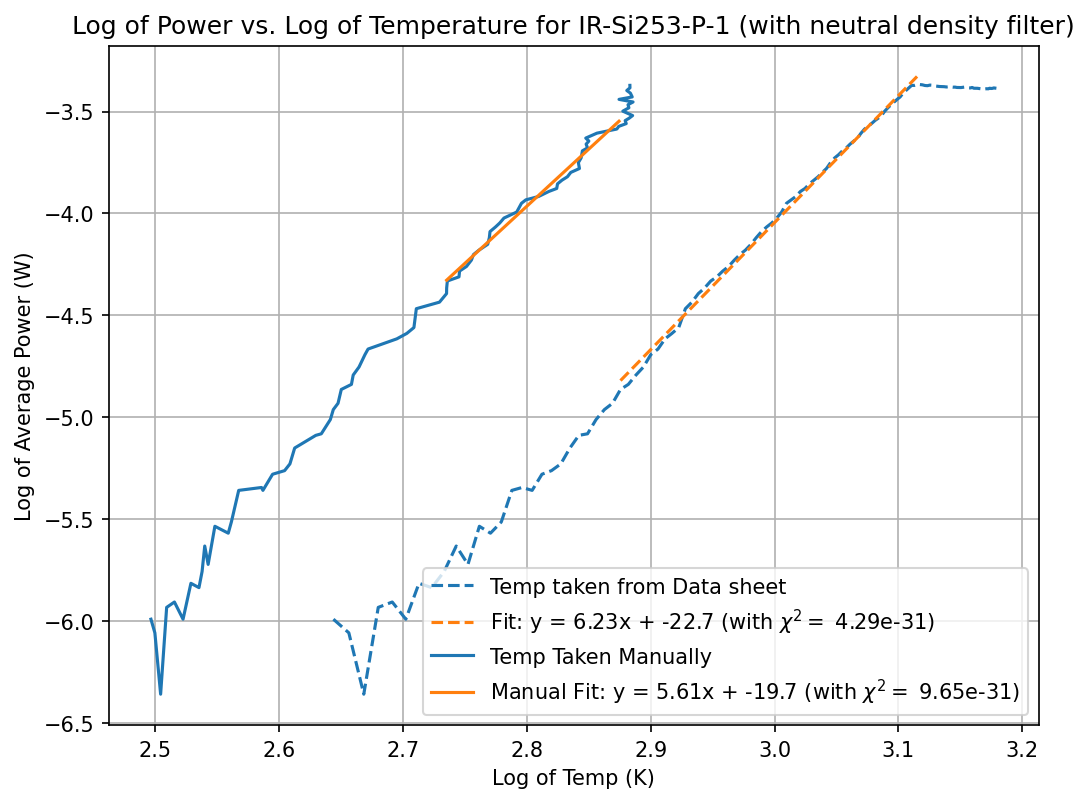

In [191]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)

if calculate_chi_sqs:
  start, end, chi = get_fit_range(temp, power)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 38
  end = 82
  chi =  9.649005409101195e-31

fig = figure(figsize=(8, 6), dpi=150)
poly, cov = np.polyfit(np.log10(temp[start:end]), np.log10(power[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit_manual = np.poly1d(poly)
fit_string_manual = 'Manual Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit_manual[1], fit_manual[0], chi)
print(fit_string_manual)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 
t_manual = np.linspace(np.log10(temp[start]), np.log10(temp[end]), 100)

plt.plot(np.log10(nofilter_temps_Si253), np.log10(nofilter_averages_Si253), label = "Temp taken from Data sheet", linestyle='--',)
plt.plot(t, fit(t), label = fit_string, linestyle='--',)
plt.plot(np.log10(temp), np.log10(power), label = "Temp Taken Manually", color = "C0")
plt.plot(t_manual, fit_manual(t_manual), label = fit_string_manual,  color = "C1")
title = "Log of Power vs. Log of Temperature for IR-Si253-P-1 (with neutral density filter)"
plt.title(title)
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

## IR-12K Source Plots

In [192]:
d_0 = {
'time_log_nofilter_IR12K' : [],

'power_nofilter_IR12K' : data_nofilter_IR12K['power'],
'time_nofilter_IR12K' : np.arange(0, len(data_nofilter_IR12K['power'])/5, 0.2)
}

seconds = 15
start_v = 1.1 #V
increase_v = 0.1 #V
fill_time_log_array('nofilter_IR12K', seconds, start_v, increase_v)

nofilter_voltages_IR12K, nofilter_averages_IR12K, nofilter_std_error_IR12K = get_data_auto('nofilter_IR12K', seconds)

[1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7]


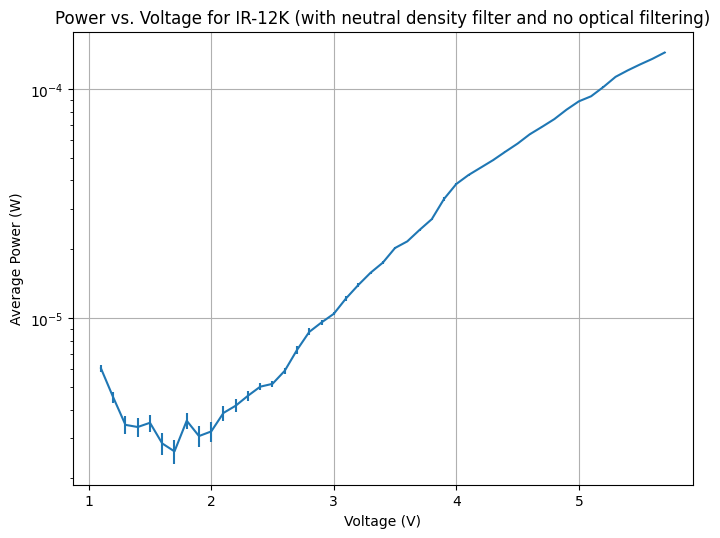

In [193]:
print(nofilter_voltages_IR12K)
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_IR12K, nofilter_averages_IR12K, yerr = nofilter_std_error_IR12K)
plt.title("Power vs. Voltage for IR-12K (with neutral density filter and no optical filtering)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.grid(True)
plt.show()

No handles with labels found to put in legend.


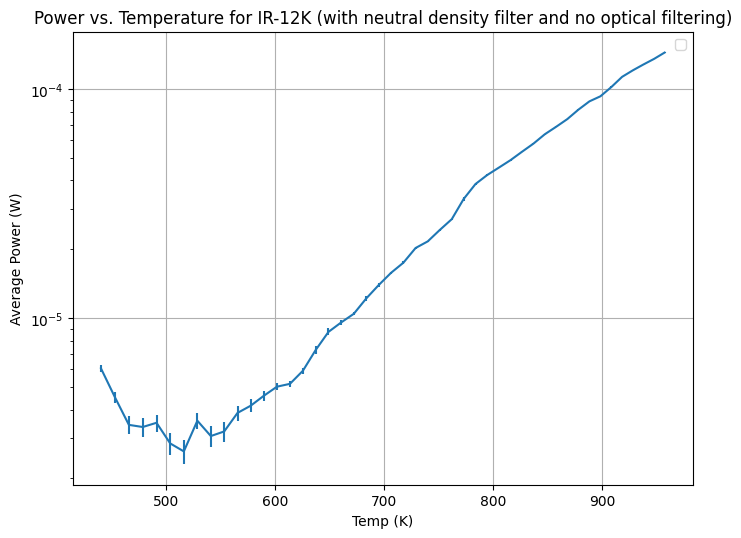

In [194]:
nofilter_temps_IR12K = Si253_temp(nofilter_voltages_IR12K)

fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_temps_IR12K, nofilter_averages_IR12K, yerr = nofilter_std_error_IR12K)

plt.title("Power vs. Temperature for IR-12K (with neutral density filter and no optical filtering)")
plt.xlabel("Temp (K)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

the range for fit (including at least 1/2 the data points) is: [ 19 , 42 ], with chi squared =  1.5434523476956742e-30
Fit: y = 7.59x + -26.4 (with $\chi^2 = $ 1.54e-30)
The diagonal elements of the covariance matrix are  [0.09929749 0.28774148]
error on the slope is  0.5364153967518765


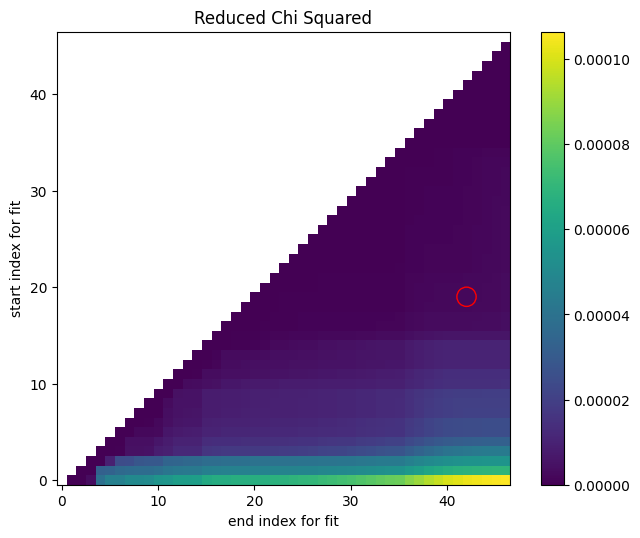

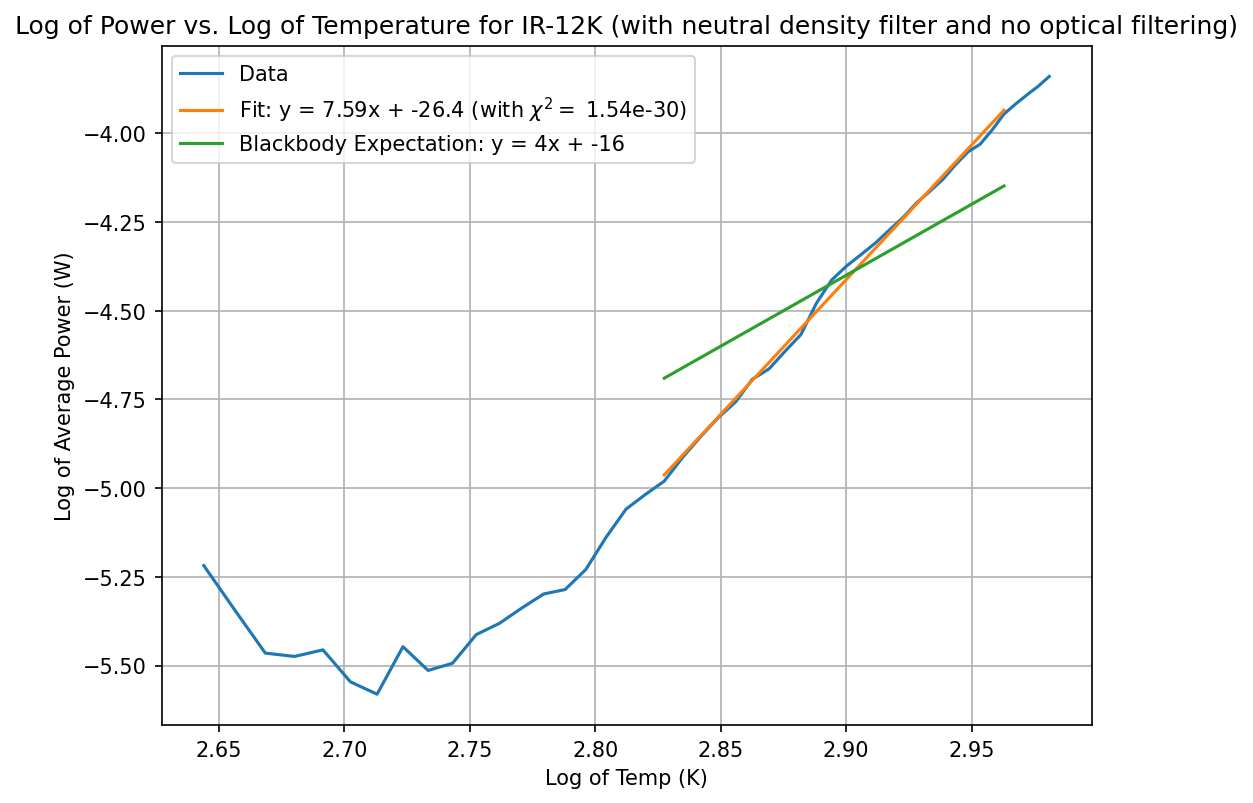

In [195]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)

if calculate_chi_sqs:
  start, end, chi = get_fit_range(nofilter_temps_IR12K, power)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 19
  end = 42
  chi =  1.5434523476956742e-30

fig = figure(figsize=(8, 6), dpi=150)

p, cov = np.polyfit(np.log10(nofilter_temps_IR12K[start:end]), np.log10(nofilter_averages_IR12K[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit = np.poly1d(p)
fit_string = 'Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit[1], fit[0], chi)
print(fit_string)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1]))
t = np.linspace(np.log10(nofilter_temps_IR12K[start]), np.log10(nofilter_temps_IR12K[end]), 100)

plt.plot(np.log10(nofilter_temps_IR12K), np.log10(nofilter_averages_IR12K), label = "Data")
plt.plot(t, fit(t), label = fit_string)
plt.plot(t, 4*t -16, label = "Blackbody Expectation: y = 4x + -16")
plt.title("Log of Power vs. Log of Temperature for IR-12K (with neutral density filter and no optical filtering)")
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

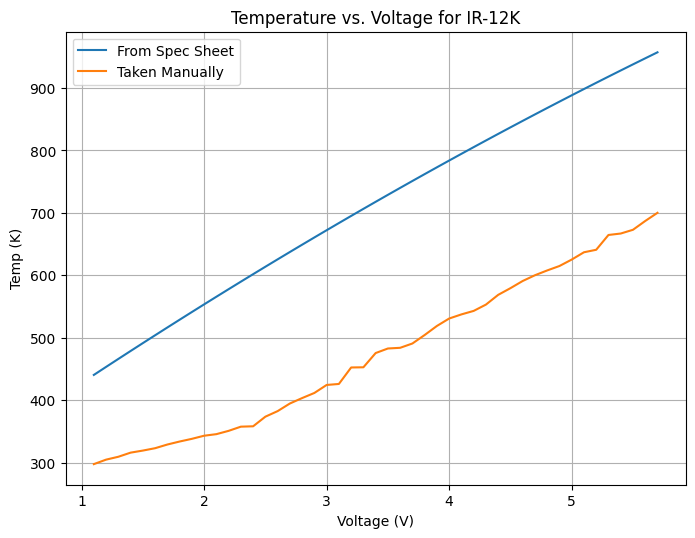

In [196]:
cleanedTempList = [x for x in IR12K_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in IR12K_temp_manual['Voltage'] if str(x) != 'nan']

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(nofilter_voltages_IR12K, nofilter_temps_IR12K, label = "From Spec Sheet")
plt.plot(cleanedVoltList, cleanedTempList, label = "Taken Manually")
plt.title("Temperature vs. Voltage for IR-12K")
plt.xlabel("Voltage (V)")
plt.ylabel("Temp (K)")

plt.legend()
plt.grid(True)
plt.show()

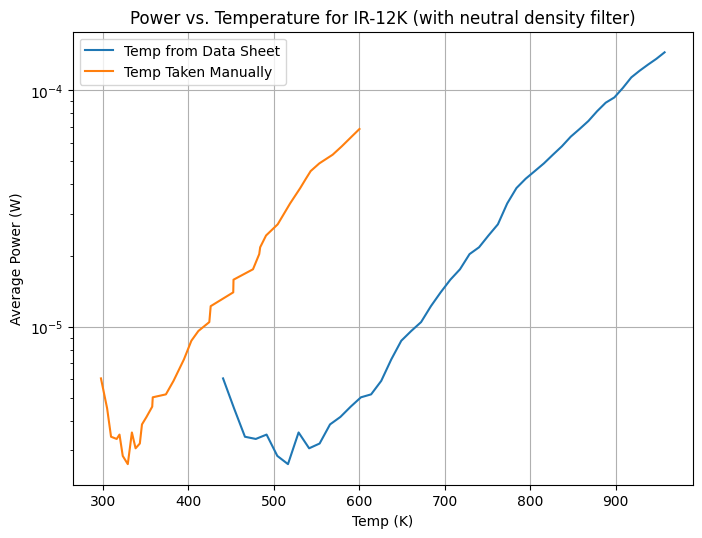

In [197]:
#eliminating any nan elements in the list
cleanedTempList = [x for x in IR12K_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in IR12K_temp_manual['Voltage'] if str(x) != 'nan']

#constructing a lookup table from voltages to temperatures 
temp_ranges = [cleanedTempList[v] for v in range(len(cleanedVoltList))] 
IR12K_volt_to_temp_manual = dict(zip(cleanedVoltList, temp_ranges))

temp = []
power = []
for i in range(len(nofilter_voltages_IR12K)):
  if i < len(cleanedTempList)-10:
    temp.append(IR12K_volt_to_temp_manual[nofilter_voltages_IR12K[i]])
    power.append(nofilter_averages_IR12K[i])

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(nofilter_temps_IR12K, nofilter_averages_IR12K, label = "Temp from Data Sheet")
plt.plot(temp, power, label = "Temp Taken Manually")
plt.title("Power vs. Temperature for IR-12K (with neutral density filter)")
plt.xlabel("Temp (K)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be poorly conditioned
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RankWarning: Polyfit may be po

the range for fit (including at least 1/2 the data points) is: [ 10 , 28 ], with chi squared =  1.5403913892003766e-30
Manual Fit: y = 5.09x + -18.3 (with $\chi^2 = $ 1.54e-30)
The diagonal elements of the covariance matrix are  [0.12071914 0.31642165]
error on the slope is  0.5625136885388505


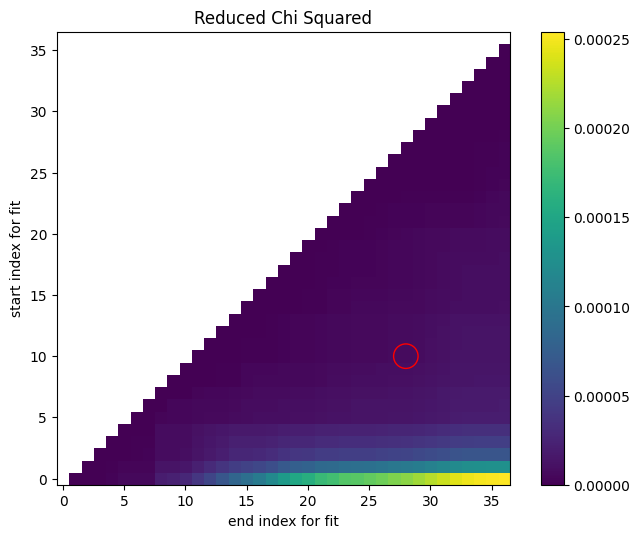

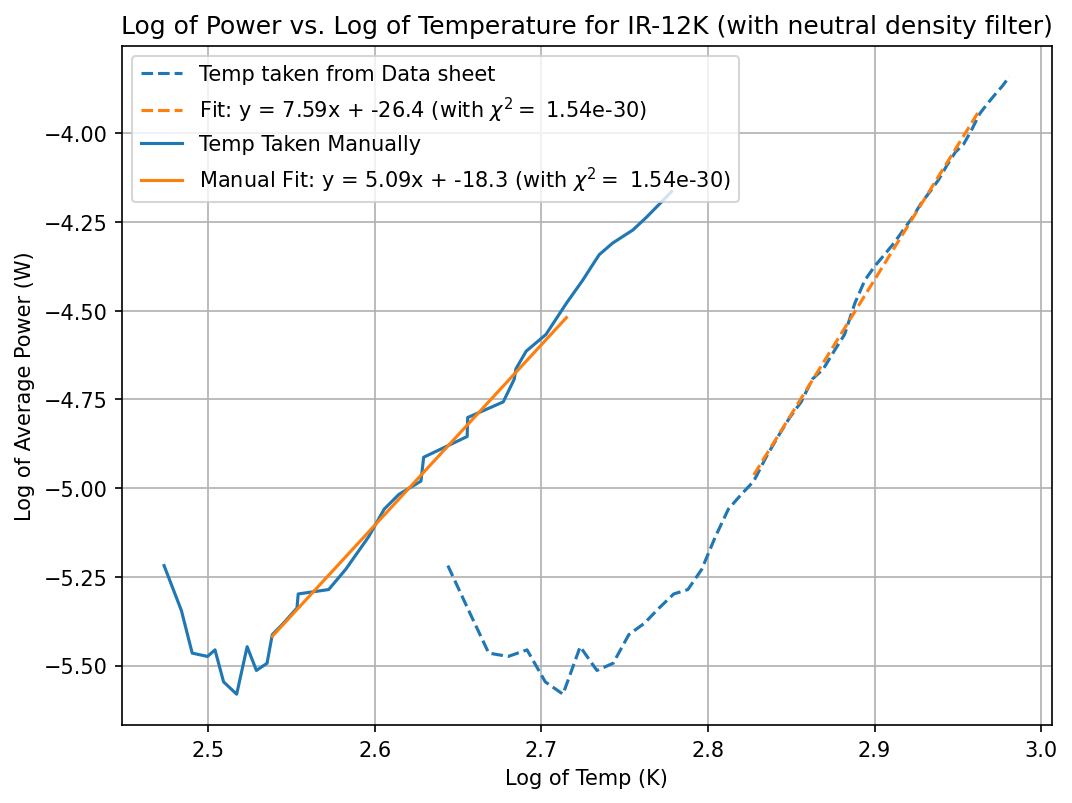

In [198]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)

if calculate_chi_sqs:
  start, end, chi = get_fit_range(temp, power)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 10
  end = 28
  chi = 1.5403913892003766e-30

fig = figure(figsize=(8, 6), dpi=150)
poly, cov = np.polyfit(np.log10(temp[start:end]), np.log10(power[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit_manual = np.poly1d(poly)
fit_string_manual = 'Manual Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit_manual[1], fit_manual[0], chi)
print(fit_string_manual)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 
t_manual = np.linspace(np.log10(temp[start]), np.log10(temp[end]), 100)

plt.plot(np.log10(nofilter_temps_IR12K), np.log10(nofilter_averages_IR12K), label = "Temp taken from Data sheet", linestyle='--',)
plt.plot(t, fit(t), label = fit_string, linestyle='--',)
plt.plot(np.log10(temp), np.log10(power), label = "Temp Taken Manually", color = "C0")
plt.plot(t_manual, fit_manual(t_manual), label = fit_string_manual,  color = "C1")
title = "Log of Power vs. Log of Temperature for IR-12K (with neutral density filter)"
plt.title(title )
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

## EVF5551 Source Plots

Plots for EVF 5551 source. I suspect I broke this source, because the first time I took data I recieved the output plot shown in blue, where the source glowed and acted normal. The maximum voltage on the source is 1.4V, after realizing this, data was taken again at lower voltages (seen in orange) and was essentially 0.

In [199]:
d_0 = {
'time_log_nofilter_EVF_5551' : [],
'time_log_nofilter_EVF_5551_try2' : [],

'power_nofilter_EVF_5551' : data_nofilter_EVF_5551['power'],
'time_nofilter_EVF_5551' : np.arange(0, len(data_nofilter_EVF_5551['power'])/5, 0.2),

'power_nofilter_EVF_5551_try2' : data_nofilter_EVF_5551_try2['power'],
'time_nofilter_EVF_5551_try2' : np.arange(0, len(data_nofilter_EVF_5551_try2['power'])/5, 0.2)
}

seconds = 15

start_v = 1.1 #V
increase_v = 0.1 #V
fill_time_log_array('nofilter_EVF_5551', seconds, start_v, increase_v)
fill_time_log_array('nofilter_EVF_5551_try2', seconds, start_v, increase_v)

nofilter_voltages_EVF_5551, nofilter_averages_EVF_5551, nofilter_std_error_EVF_5551 = get_data_auto('nofilter_EVF_5551', seconds)
nofilter_voltages_EVF_5551_try2, nofilter_averages_EVF_5551_try2, nofilter_std_error_EVF_5551_try2 = get_data_auto('nofilter_EVF_5551_try2', seconds)

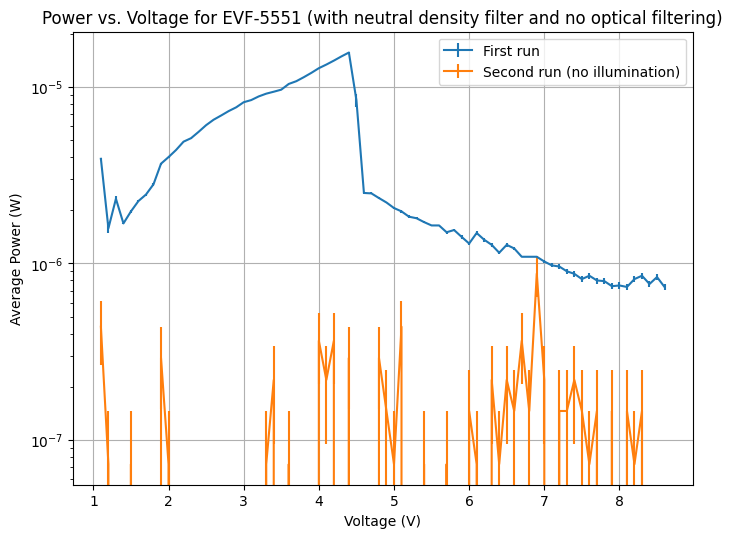

In [200]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_EVF_5551, nofilter_averages_EVF_5551, yerr = nofilter_std_error_EVF_5551, label = "First run")
plt.errorbar(nofilter_voltages_EVF_5551_try2, nofilter_averages_EVF_5551_try2, yerr = nofilter_std_error_EVF_5551_try2, label = "Second run (no illumination)")
plt.title("Power vs. Voltage for EVF-5551 (with neutral density filter and no optical filtering)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

## EVF5550 Source Plots

Plots for EVF 5550 source. This source was strategically run at low voltages to avoid damages which may have occured to the 5551 source. The first time data was taken data I recieved the output plot shown in blue, where the source glowed and acted normal. When this run was repeated at the same voltages (seen in orange) the result was essentially 0.

In [201]:
d_0 = {
'time_log_nofilter_EVF_5550' : [],
'time_log_nofilter_EVF_5550_try2' : [],

'power_nofilter_EVF_5550' : data_nofilter_EVF_5550['power'],
'time_nofilter_EVF_5550' : np.arange(0, len(data_nofilter_EVF_5550['power'])/5, 0.2),
'power_nofilter_EVF_5550_try2' : data_nofilter_EVF_5550_try2['power'],
'time_nofilter_EVF_5550_try2' : np.arange(0, len(data_nofilter_EVF_5550_try2['power'])/5, 0.2)
}

seconds = 15

start_v = 0.01 #V
increase_v = 0.01 #V
fill_time_log_array('nofilter_EVF_5550', seconds, start_v, increase_v)
fill_time_log_array('nofilter_EVF_5550_try2', seconds, start_v, increase_v)

nofilter_voltages_EVF_5550, nofilter_averages_EVF_5550, nofilter_std_error_EVF_5550 = get_data_auto('nofilter_EVF_5550', seconds)
nofilter_voltages_EVF_5550_try2, nofilter_averages_EVF_5550_try2, nofilter_std_error_EVF_5550_try2 = get_data_auto('nofilter_EVF_5550_try2', seconds)

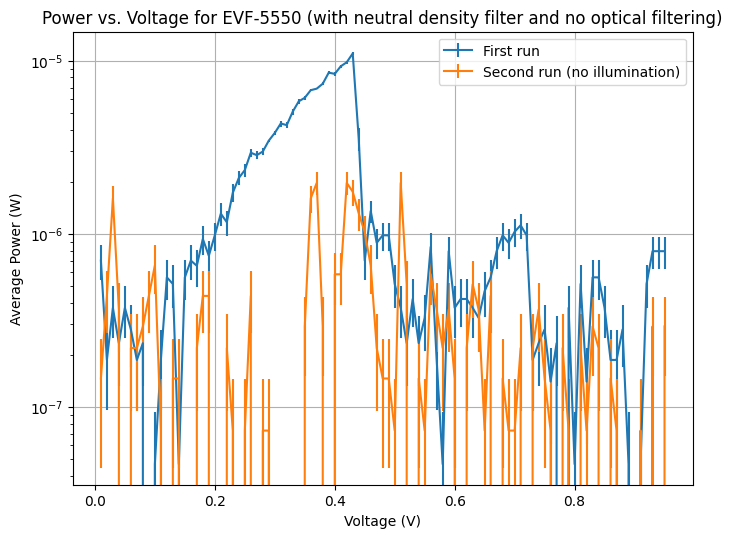

In [202]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_EVF_5550, nofilter_averages_EVF_5550, yerr = nofilter_std_error_EVF_5550, label = "First run")
plt.errorbar(nofilter_voltages_EVF_5550_try2, nofilter_averages_EVF_5550_try2, yerr = nofilter_std_error_EVF_5550_try2, label = "Second run (no illumination)")
plt.title("Power vs. Voltage for EVF-5550 (with neutral density filter and no optical filtering)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

## Si207 Source Plots

In [203]:
d_0 = {
'time_log_nofilter_Si207' : [],
'time_log_nofilter_Si207_633nm' : [],
'time_log_nofilter_Si207_1e4nm' : [],
'time_log_nofilter_Si207_5e4nm' : [],
'time_log_nofilter_Si207_3e5nm' : [],
'time_log_PEWfilter_Si207' : [],
'time_log_SiWfilter_Si207' : [],

'power_nofilter_Si207' : data_nofilter_Si207['power'],
'time_nofilter_Si207' : np.arange(0, len(data_nofilter_Si207['power'])/5, 0.2),

'power_nofilter_Si207_633nm' : data_nofilter_Si207_633nm['power'],
'time_nofilter_Si207_633nm' : np.arange(0, len(data_nofilter_Si207_633nm['power'])/5, 0.2),

'power_nofilter_Si207_1e4nm' : data_nofilter_Si207_1e4nm['power'],
'time_nofilter_Si207_1e4nm' : np.arange(0, len(data_nofilter_Si207_1e4nm['power'])/5, 0.2),

'power_nofilter_Si207_3e5nm' : data_nofilter_Si207_3e5nm['power'],
'time_nofilter_Si207_3e5nm' : np.arange(0, len(data_nofilter_Si207_3e5nm['power'])/5, 0.2),

'power_nofilter_Si207_5e4nm' : data_nofilter_Si207_5e4nm['power'],
'time_nofilter_Si207_5e4nm' : np.arange(0, len(data_nofilter_Si207_5e4nm['power'])/5, 0.2),


'power_PEWfilter_Si207' : data_PEWfilter_Si207['power'],
'time_PEWfilter_Si207' : np.arange(0, len(data_PEWfilter_Si207['power'])/5, 0.2),

'power_SiWfilter_Si207' : data_SiWfilter_Si207['power'],
'time_SiWfilter_Si207' : np.arange(0, len(data_SiWfilter_Si207['power'])/5, 0.2)
}

seconds = 15
start_v = 1.1 #V
increase_v = 0.1 #V
fill_time_log_array('SiWfilter_Si207', seconds, start_v, increase_v)
fill_time_log_array('PEWfilter_Si207', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si207', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si207_633nm', seconds, 1.3, increase_v)
fill_time_log_array('nofilter_Si207_1e4nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si207_3e5nm', seconds, start_v, increase_v)
fill_time_log_array('nofilter_Si207_5e4nm', seconds, start_v, increase_v)

nofilter_voltages_Si207, nofilter_averages_Si207, nofilter_std_error_Si207 = get_data_auto('nofilter_Si207', 15)
nofilter_voltages_Si207_633nm, nofilter_averages_Si207_633nm, nofilter_std_error_Si207_633nm = get_data_auto('nofilter_Si207_633nm', 15)
nofilter_voltages_Si207_1e4nm, nofilter_averages_Si207_1e4nm, nofilter_std_error_Si207_1e4nm = get_data_auto('nofilter_Si207_1e4nm', 15)
nofilter_voltages_Si207_3e5nm, nofilter_averages_Si207_3e5nm, nofilter_std_error_Si207_3e5nm = get_data_auto('nofilter_Si207_3e5nm', 15)
nofilter_voltages_Si207_5e4nm, nofilter_averages_Si207_5e4nm, nofilter_std_error_Si207_5e4nm = get_data_auto('nofilter_Si207_5e4nm', 15)
PEWfilter_voltages_Si207, PEWfilter_averages_Si207, PEWfilter_std_error_Si207 = get_data_auto('PEWfilter_Si207', 15)
SiWfilter_voltages_Si207, SiWfilter_averages_Si207, SiWfilter_std_error_Si207 = get_data_auto('SiWfilter_Si207',15)

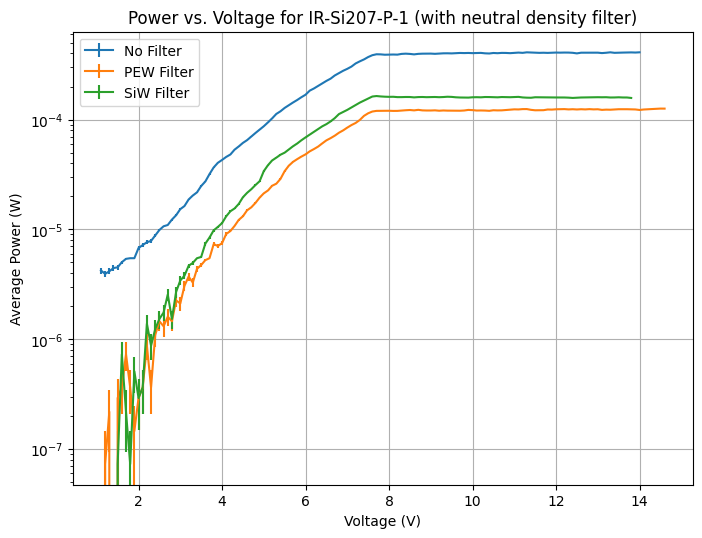

In [204]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si207, nofilter_averages_Si207, yerr = nofilter_std_error_Si207, label = "No Filter")
plt.errorbar(PEWfilter_voltages_Si207, PEWfilter_averages_Si207, yerr = PEWfilter_std_error_Si207, label = "PEW Filter")
plt.errorbar(SiWfilter_voltages_Si207, SiWfilter_averages_Si207, yerr = SiWfilter_std_error_Si207, label = "SiW Filter")
plt.title("Power vs. Voltage for IR-Si207-P-1 (with neutral density filter)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()


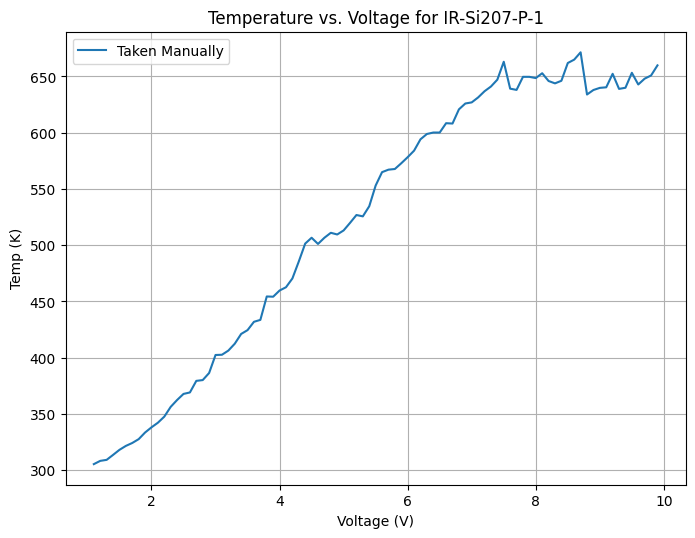

In [205]:
cleanedTempList = [x for x in Si207_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in Si207_temp_manual['Voltage'] if str(x) != 'nan']

#constructing a lookup table from voltages to temperatures 
temp_ranges = [cleanedTempList[v] for v in range(len(cleanedVoltList))] 
Si207_volt_to_temp_manual = dict(zip(cleanedVoltList, temp_ranges))

temp = []
power = []
for i in range(len(nofilter_voltages_Si207)):
  if i < len(cleanedTempList)-10:
    temp.append(Si207_volt_to_temp_manual[nofilter_voltages_Si207[i]])
    power.append(nofilter_averages_Si207[i])

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(cleanedVoltList, cleanedTempList, label = "Taken Manually")
plt.title("Temperature vs. Voltage for IR-Si207-P-1")
plt.xlabel("Voltage (V)")
plt.ylabel("Temp (K)")

plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packa

the range for fit (including at least 1/2 the data points) is: [ 24 , 63 ], with chi squared =  4.278445644970472e-31
Manuall Fit: y = 6.23x + -21 (with $\chi^2 = $ 4.28e-31)
The diagonal elements of the covariance matrix are  [0.10322574 0.28189782]
error on the slope is  0.5309405013867818


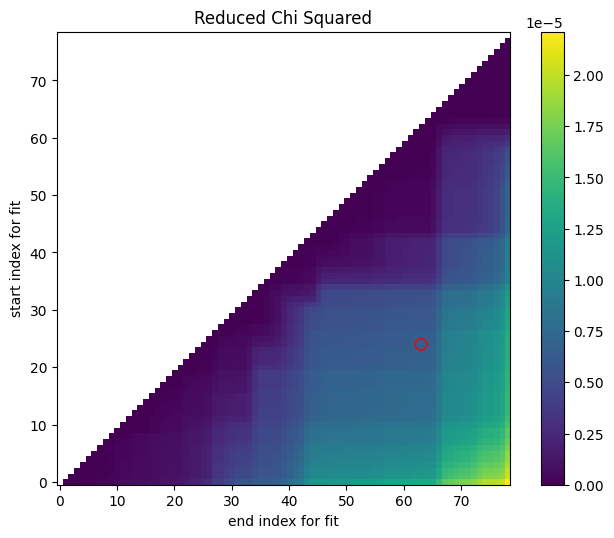

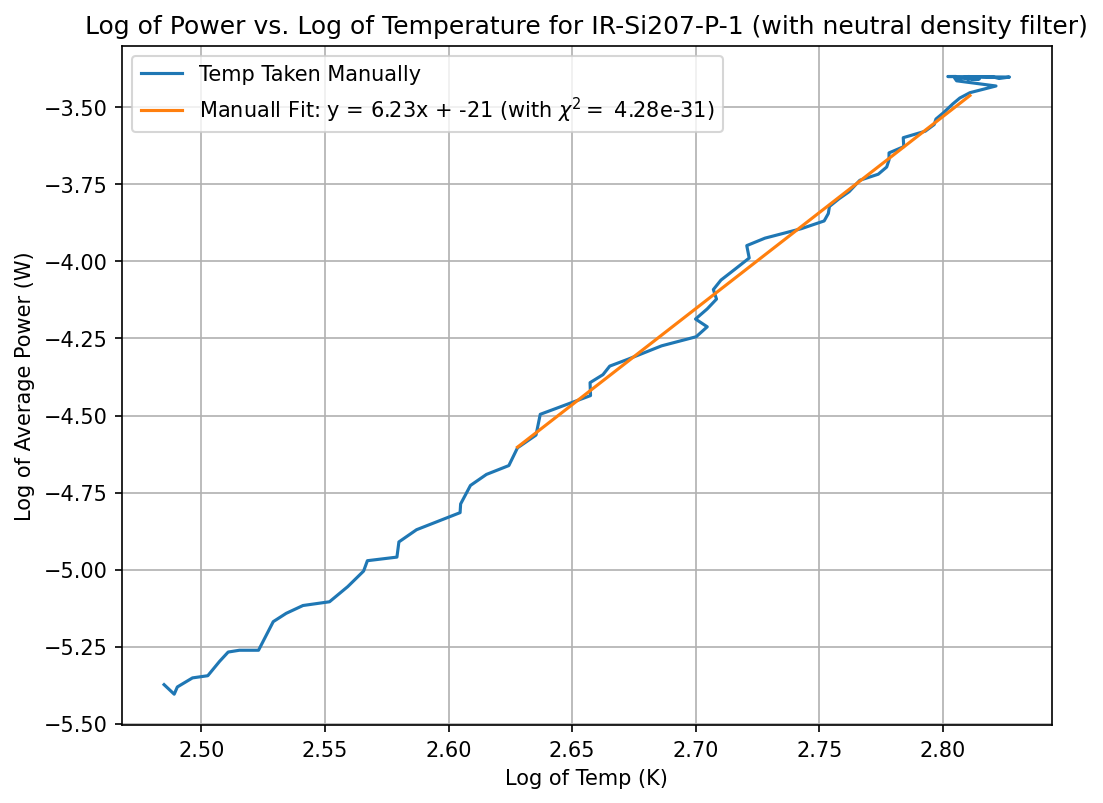

In [206]:
#Fitting the power vs temp data to a log log to extract power law. Expect something comporable to P = k*T^+ c (which looks like power law to the 4)
if calculate_chi_sqs:
  start, end, chi = get_fit_range(temp, power)
else:
  #in order to avoid running the long chi squared code every time I am manually entering the start end and chi squared values
  #as calcualted in earlier iterations of running this code
  start = 24
  end = 63
  chi = 4.278445644970472e-31

fig = figure(figsize=(8, 6), dpi=150)
poly, cov = np.polyfit(np.log10(temp[start:end]), np.log10(power[start:end]), 1, cov=True )
diag_cov = np.sqrt(np.diag(cov))
fit_manual = np.poly1d(poly)
fit_string_manual = 'Manuall Fit: y = {0:.3g}x + {1:.3g} (with $\chi^2 = $ {2:.3g})'.format(fit_manual[1], fit_manual[0], chi)
print(fit_string_manual)
print("The diagonal elements of the covariance matrix are ", diag_cov)
print("error on the slope is ", np.sqrt(diag_cov[1])) 
t_manual = np.linspace(np.log10(temp[start]), np.log10(temp[end]), 100)

plt.plot(np.log10(temp), np.log10(power), label = "Temp Taken Manually")
plt.plot(t_manual, fit_manual(t_manual), label = fit_string_manual)
plt.title("Log of Power vs. Log of Temperature for IR-Si207-P-1 (with neutral density filter)")
plt.xlabel("Log of Temp (K)")
plt.ylabel("Log of Average Power (W)")
plt.legend()
plt.grid(True)
plt.show()

# This section begins random comparison plots to investigate behaviors

This plot is still for the Si253 source. Investigates the difference in data taking time at each voltage step. The 15 second data point means the source was fixed at a input voltage for 15 seconds (with step size of 0.1V) and 30 seconds means the source was fixed for 30 seconds at an input voltage. 

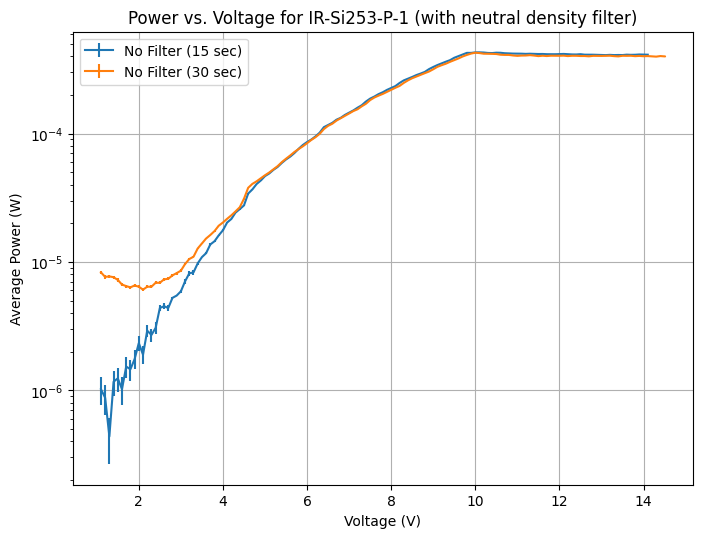

In [207]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si253, nofilter_averages_Si253, yerr = nofilter_std_error_Si253, label = "No Filter (15 sec)")
plt.errorbar(nofilter_voltages_Si253_30sec, nofilter_averages_Si253_30sec, yerr = nofilter_std_error_Si253_30sec, label = "No Filter (30 sec)")
plt.title("Power vs. Voltage for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

This plot shows the differnece made by the neutral density filter (piece of cardboard with hole in it). There is a clear amount of optical power being allowed through the filter thanks to the hole in the cardboard. 

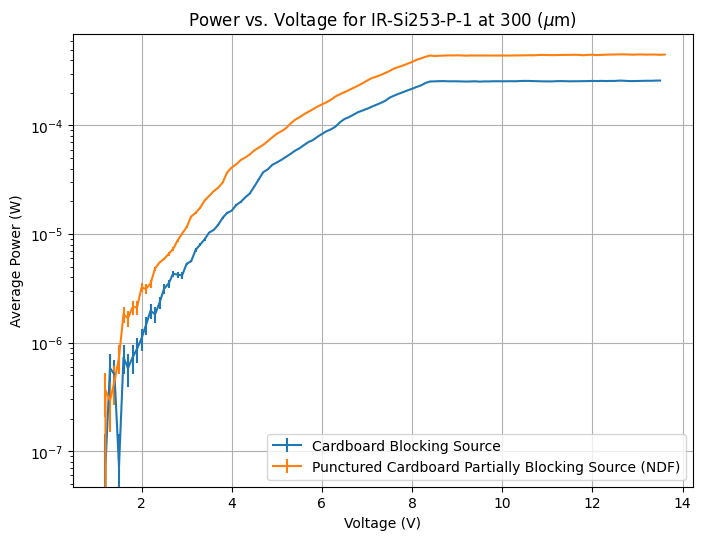

In [208]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si253_block, nofilter_averages_Si253_block, yerr = nofilter_std_error_Si253_block, label = "Cardboard Blocking Source") 
plt.errorbar(nofilter_voltages_Si253_3e5nm, nofilter_averages_Si253_3e5nm, yerr = nofilter_std_error_Si253_3e5nm, label = "Punctured Cardboard Partially Blocking Source (NDF)") 
plt.title("Power vs. Voltage for IR-Si253-P-1 at 300 ($\mu$m) ")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

### These four plots (three of Si253 and one of Si207 respectivley) compare data taken where the selected wavelength of investigation on the detector is modified. Final results conclude that the detector measures overall power and multiplies the measured value by some adjustment value accoridng to it's acceptance as a function of wavlength. The final reuslts are shown in the typical and then log scale (2nd and 3rd plot), comparing the power at various wavlengths for a fixed temperaute.  This plot has the same shape as the detector's acceptance plot. 

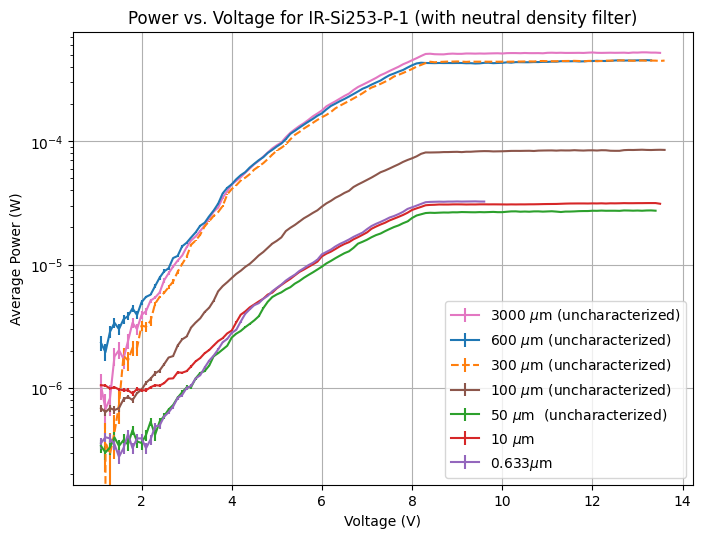

In [209]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si253_3e6nm, nofilter_averages_Si253_3e6nm, yerr = nofilter_std_error_Si253_3e6nm, label = "3000 $\mu$m (uncharacterized)", color = 'C6') 
plt.errorbar(nofilter_voltages_Si253_6e5nm, nofilter_averages_Si253_6e5nm, yerr = nofilter_std_error_Si253_6e5nm, label = "600 $\mu$m (uncharacterized)", color = 'C0')  
#plt.errorbar(nofilter_voltages_Si253, nofilter_averages_Si253, yerr = nofilter_std_error_Si253, label = "300 $\mu$m (uncharacterized) data taken Feb. 25", color='C1')
#plt.errorbar(nofilter_voltages_Si253_3e5nm, nofilter_averages_Si253_3e5nm, yerr = nofilter_std_error_Si253_3e5nm, label = "300 $\mu$m (uncharacterized) data taken Mar. 5", linestyle='--', color='C1')#
plt.errorbar(nofilter_voltages_Si253_3e5nm, nofilter_averages_Si253_3e5nm, yerr = nofilter_std_error_Si253_3e5nm, label = "300 $\mu$m (uncharacterized)", linestyle='--', color='C1')
plt.errorbar(nofilter_voltages_Si253_1e5nm, nofilter_averages_Si253_1e5nm, yerr = nofilter_std_error_Si253_1e5nm, label = "100 $\mu$m (uncharacterized)", color = 'C5')
plt.errorbar(nofilter_voltages_Si253_5e4nm, nofilter_averages_Si253_5e4nm, yerr = nofilter_std_error_Si253_5e4nm, label = "50 $\mu$m  (uncharacterized)", color = 'C2')
plt.errorbar(nofilter_voltages_Si253_1e4nm, nofilter_averages_Si253_1e4nm, yerr = nofilter_std_error_Si253_1e4nm, label = "10 $\mu$m", color = 'C3')
plt.errorbar(nofilter_voltages_Si253_633nm, nofilter_averages_Si253_633nm, yerr = nofilter_std_error_Si253_633nm, label = "0.633$\mu$m", color = 'C4')
plt.title("Power vs. Voltage for IR-Si253-P-1 (with neutral density filter)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

No handles with labels found to put in legend.


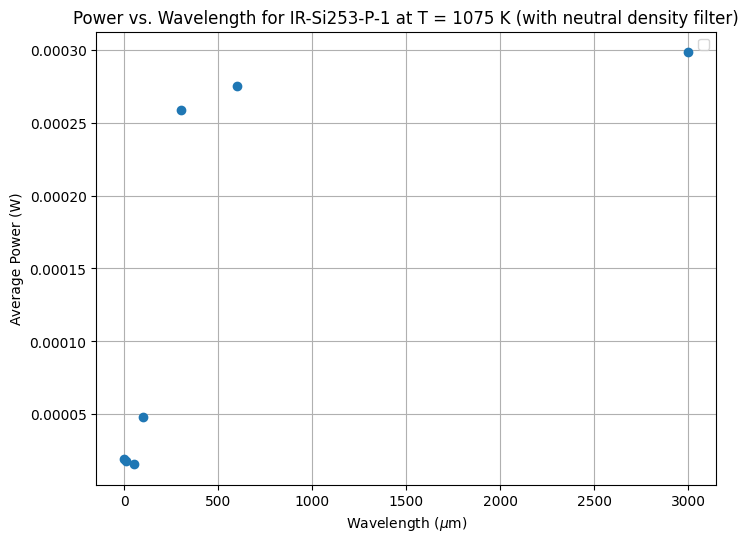

In [210]:
power_wavelength = []
power_wavelength.append([get_power(nofilter_voltages_Si253_3e6nm, nofilter_averages_Si253_3e6nm, 7),3000])
power_wavelength.append([get_power(nofilter_voltages_Si253_6e5nm, nofilter_averages_Si253_6e5nm, 7), 600])
power_wavelength.append([get_power(nofilter_voltages_Si253_3e5nm, nofilter_averages_Si253_3e5nm, 7), 300])
power_wavelength.append([get_power(nofilter_voltages_Si253_1e5nm, nofilter_averages_Si253_1e5nm, 7), 100])
power_wavelength.append([get_power(nofilter_voltages_Si253_5e4nm, nofilter_averages_Si253_5e4nm, 7), 50])
power_wavelength.append([get_power(nofilter_voltages_Si253_1e4nm, nofilter_averages_Si253_1e4nm, 7), 10])
power_wavelength.append([get_power(nofilter_voltages_Si253_633nm, nofilter_averages_Si253_633nm, 7), 0.633])
powerwavelength = np.asarray(power_wavelength, dtype=np.float32)

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(powerwavelength[:,1], powerwavelength[:,0], marker='o', linestyle = "None")
plt.title("Power vs. Wavelength for IR-Si253-P-1 at T = 1075 K (with neutral density filter)")
plt.xlabel("Wavelength ($\mu$m)")
plt.ylabel("Average Power (W)")
plt.legend()
#plt.yscale("log")
#plt.xscale("log")
plt.grid(True)
plt.show()

No handles with labels found to put in legend.


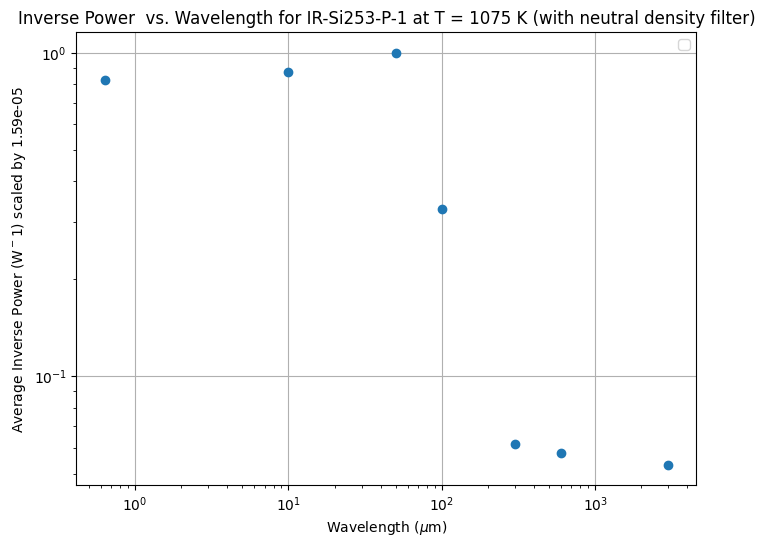

In [211]:
one_over = 1/powerwavelength
wavelength_plot_new = one_over*np.min(powerwavelength[:,0])

fig = figure(figsize=(8, 6), dpi=100)
plt.plot(powerwavelength[:,1], wavelength_plot_new[:,0], marker='o', linestyle = "None")
plt.title("Inverse Power  vs. Wavelength for IR-Si253-P-1 at T = 1075 K (with neutral density filter)")
plt.xlabel("Wavelength ($\mu$m)")

ystr = 'Average Inverse Power (W$^-1$) scaled by {0:.3g} '.format(np.min(powerwavelength[:,0])) 
plt.ylabel(ystr)
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

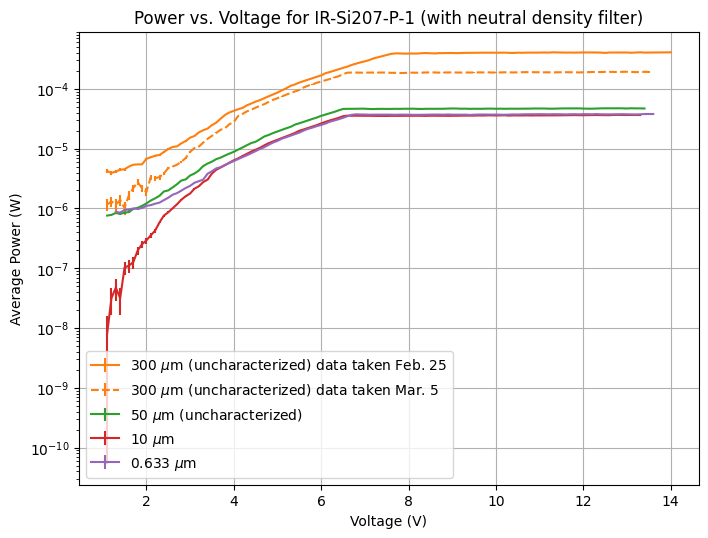

In [212]:
fig = figure(figsize=(8, 6), dpi=100)
plt.errorbar(nofilter_voltages_Si207, nofilter_averages_Si207, yerr = nofilter_std_error_Si207, label = "300 $\mu$m (uncharacterized) data taken Feb. 25", color = "C1")
plt.errorbar(nofilter_voltages_Si207_3e5nm, nofilter_averages_Si207_3e5nm, yerr = nofilter_std_error_Si207_3e5nm, label = "300 $\mu$m (uncharacterized) data taken Mar. 5", linestyle='--', color = "C1")
plt.errorbar(nofilter_voltages_Si207_5e4nm, nofilter_averages_Si207_5e4nm, yerr = nofilter_std_error_Si207_5e4nm, label = "50 $\mu$m (uncharacterized)", color = 'C2')
plt.errorbar(nofilter_voltages_Si207_1e4nm, nofilter_averages_Si207_1e4nm, yerr = nofilter_std_error_Si207_1e4nm, label = "10 $\mu$m", color = 'C3')
plt.errorbar(nofilter_voltages_Si207_633nm, nofilter_averages_Si207_633nm, yerr = nofilter_std_error_Si207_633nm, label = "0.633 $\mu$m", color = 'C4')
plt.title("Power vs. Voltage for IR-Si207-P-1 (with neutral density filter)")
plt.xlabel("Voltage (V)")
plt.ylabel("Average Power (W)")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

## Background Power (no source)

In [213]:
def get_std_error(array):
  std_dev = np.sqrt(np.var(array))
  std_error = std_dev/np.sqrt(len(array))
  return(std_error)

d_0 = {'power_nosource' : data_nosource['power'] }
avg_power_nosource = np.mean(d_0['power_nosource'])
err_power_nosource = get_std_error(d_0['power_nosource'])

print("background power is " , avg_power_nosource, u"\u00B1", err_power_nosource , "W")

background power is  1.258559195716976e-08 ± 7.895543912493363e-11 W


## LED Source Plots

The goal of these data is to show how much optical power the detector measures for an LED with a narrow wavelength range (2.35 micron). It is expected that the SiW optical filter should allow light in the ranges: [1.1$\mu$m, 9.9$\mu$m] & [50$\mu$m, 1000$\mu$m] meaning the detector can observe the LED with the SiW filter in place, whereas the PEW filter should not allow the LED to reach the detector, since its optical range is [10$\mu$m, 1000$\mu$m].

Also, the Noise Equivalent power accoring to the detector speifications is 5nW. This will also be plotted for visualtization purposes.  

No handles with labels found to put in legend.


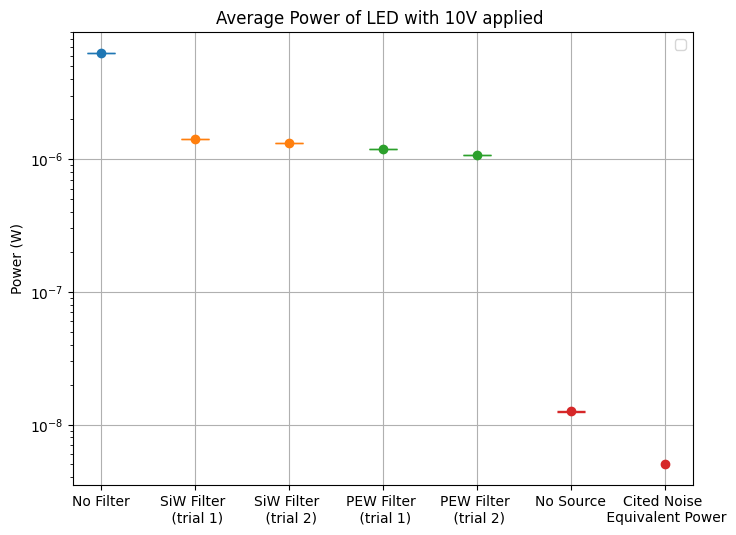

In [214]:
d_0 = {
'power_data_LED_nofilter' : data_LED_nofilter['power'],
'power_data_LED_SiWfilter1' : data_LED_SiWfilter1['power'],
'power_data_LED_SiWfilter2' : data_LED_SiWfilter2['power'],
'power_data_LED_PEWfilter1' : data_LED_PEWfilter1['power'],
'power_data_LED_PEWfilter2' : data_LED_PEWfilter2['power'],
}

noise_equivalent_power = 5e-9

avg_power_LED_nofilter = np.mean(d_0['power_data_LED_nofilter'])
avg_power_LED_SiWfilter1 = np.mean(d_0['power_data_LED_SiWfilter1'])
avg_power_LED_SiWfilter2 = np.mean(d_0['power_data_LED_SiWfilter2'])
avg_power_LED_PEWfilter1 = np.mean(d_0['power_data_LED_PEWfilter1'])
avg_power_LED_PEWfilter2 = np.mean(d_0['power_data_LED_PEWfilter2'])

err_power_LED_nofilter = get_std_error(d_0['power_data_LED_nofilter'])
err_power_LED_SiWfilter1 = get_std_error(d_0['power_data_LED_SiWfilter1'])
err_power_LED_SiWfilter2 = get_std_error(d_0['power_data_LED_SiWfilter2'])
err_power_LED_PEWfilter1 = get_std_error(d_0['power_data_LED_PEWfilter1'])
err_power_LED_PEWfilter2 = get_std_error(d_0['power_data_LED_PEWfilter2'])

fig = figure(figsize=(8, 6), dpi=100)
x = np.arange(8)
plt.xticks(x, ('', 'No Filter', 'SiW Filter \n (trial 1)', 'SiW Filter \n (trial 2)', 'PEW Filter \n (trial 1)', 'PEW Filter \n (trial 2)', 'No Source', 'Cited Noise \n Equivalent Power'))

plt.errorbar(1, avg_power_LED_nofilter, yerr = err_power_LED_nofilter, color = "C0", fmt='o', capsize=10)
plt.errorbar(2, avg_power_LED_SiWfilter1, yerr = err_power_LED_SiWfilter1, color = "C1", fmt='o', capsize=10)
plt.errorbar(3, avg_power_LED_SiWfilter2, yerr = err_power_LED_SiWfilter2,  color = 'C1', fmt='o', capsize=10)
plt.errorbar(4, avg_power_LED_PEWfilter1, yerr = err_power_LED_PEWfilter1, color = 'C2', fmt='o', capsize=10)
plt.errorbar(5, avg_power_LED_PEWfilter2, yerr = err_power_LED_PEWfilter2, color = 'C2', fmt='o', capsize=10)
plt.errorbar(6, avg_power_nosource, yerr = err_power_nosource, color = 'C3', fmt='o', capsize=10)
plt.plot(7,noise_equivalent_power,'o', color = 'C3')

plt.title("Average Power of LED with 10V applied ")
plt.ylabel("Power (W)")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

In [215]:
print("relative power for SiW filter is " , np.mean([avg_power_LED_SiWfilter1, avg_power_LED_SiWfilter2])/ avg_power_LED_nofilter )
print("relative power for PEW filter is " , np.mean([avg_power_LED_PEWfilter1, avg_power_LED_PEWfilter2])/ avg_power_LED_nofilter )

relative power for SiW filter is  0.2159291332474294
relative power for PEW filter is  0.17850823822736392


In [216]:
print(avg_power_LED_nofilter)

6.328151549942651e-06
